In [4]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

### Carga y transformación

In [12]:
ruta = 'data/clean_data/nasdaq.csv'
serie = pd.read_csv(ruta, names=['Valores'])

# 1.1 Logaritmo
s_log = np.log(serie['Valores'].values)

# 1.2 Diferenciación
s_diff = np.diff(s_log, n=1)  # Serie estacionaria

# 1.3 DIVISIÓN ANTES DE NORMALIZAR (para evitar data leakage)
total_len = len(s_diff)
train_size = int(total_len * 0.8)
val_size = int(total_len * 0.1)
test_size = total_len - train_size - val_size

s_diff_train = s_diff[:train_size]
s_diff_val = s_diff[train_size:train_size + val_size]
s_diff_test = s_diff[train_size + val_size:]

# 1.4 Normalización (solo con datos de entrenamiento)
scaler = StandardScaler()
s_diff_train_norm = scaler.fit_transform(s_diff_train.reshape(-1, 1)).flatten()
s_diff_val_norm = scaler.transform(s_diff_val.reshape(-1, 1)).flatten()
s_diff_test_norm = scaler.transform(s_diff_test.reshape(-1, 1)).flatten()

# Guardar media y desviación para desnormalizar después
mu = scaler.mean_[0]
sigma = scaler.scale_[0]

print(f"Datos totales: {total_len}")
print(f"Train: {len(s_diff_train_norm)}, Val: {len(s_diff_val_norm)}, Test: {len(s_diff_test_norm)}")
print(f"Media (mu): {mu:.6f}, Desviación (sigma): {sigma:.6f}")

Datos totales: 1499
Train: 1199, Val: 149, Test: 151
Media (mu): 0.000420, Desviación (sigma): 0.008587


### Crear ventanas

In [13]:
def crear_ventanas(serie, ventana):
    X, y = [], []
    for i in range(len(serie) - ventana):
        X.append(serie[i:i + ventana])
        y.append(serie[i + ventana])
    return np.array(X), np.array(y)

ventana = 100

# Crear ventanas para cada conjunto
X_train, y_train = crear_ventanas(s_diff_train_norm, ventana)
X_val, y_val = crear_ventanas(s_diff_val_norm, ventana)
X_test, y_test = crear_ventanas(s_diff_test_norm, ventana)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (1099, 100), y_train shape: (1099,)
X_val shape: (49, 100), y_val shape: (49,)
X_test shape: (51, 100), y_test shape: (51,)


### Convertir en tensores

In [14]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)

y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Crear datasets y dataloaders (shuffle=False para series temporales)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Verificar una muestra
for xb, yb in train_loader:
    print(f"\nBatch shape: X={xb.shape}, y={yb.shape}")
    break


Batch shape: X=torch.Size([32, 1, 100]), y=torch.Size([32])


### Definir el modelo CNN 1D

In [8]:
class SimpleConv1DRegressor(nn.Module):
    def __init__(self, input_channels=1, window_size=100):
        super().__init__()
        self.conv_blocks = nn.Sequential(
            # Bloque 1
            nn.Conv1d(input_channels, 32, kernel_size=5, padding=2),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(2),  # 100 → 50
            
            # Bloque 2
            nn.Conv1d(32, 64, kernel_size=5, padding=2),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.MaxPool1d(5),  # 50 → 10
            
            # Bloque 3
            nn.Conv1d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)  # 10 → 1
        )
        
        # MLP final más simple
        self.fc = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(64, 1)
        )
    
    def forward(self, x):
        x = self.conv_blocks(x)  # (batch, 128, 1)
        x = x.squeeze(-1)        # (batch, 128)
        return self.fc(x)

# Inicializar modelo
model = SimpleConv1DRegressor(window_size=ventana)
print(f"\nModelo creado. Total parámetros: {sum(p.numel() for p in model.parameters()):,}")


Modelo creado. Total parámetros: 43,969


### Funciónes para entrenamiento

In [15]:
def train_epoch(model, train_loader, criterion, optimizer):
    model.train()
    train_loss = 0.0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target.unsqueeze(1))
        loss.backward()
        
        # Gradient clipping para evitar explosión
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        train_loss += loss.item()
    
    return train_loss / len(train_loader)

def validate_epoch(model, val_loader, criterion):
    model.eval()
    val_loss = 0.0
    
    with torch.no_grad():
        for data, target in val_loader:
            output = model(data)
            loss = criterion(output, target.unsqueeze(1))
            val_loss += loss.item()
    
    return val_loss / len(val_loader)


### Entrenamiento

In [16]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

epochs = 50
patience = 10
best_val_loss = float('inf')
patience_counter = 0
best_model_state = None

train_losses = []
val_losses = []

for epoch in range(epochs):
    print(f'\nÉpoca {epoch+1}/{epochs}')
    print('-' * 40)
    
    # Entrenar
    train_loss = train_epoch(model, train_loader, criterion, optimizer)
    train_losses.append(train_loss)
    
    # Validar
    val_loss = validate_epoch(model, val_loader, criterion)
    val_losses.append(val_loss)
    
    print(f'Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}')
    
    # Ajustar learning rate
    scheduler.step(val_loss)
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        best_model_state = model.state_dict().copy()
        print(f'Mejor modelo guardado (Val Loss: {val_loss:.6f})')
    else:
        patience_counter += 1
        print(f'Sin mejora ({patience_counter}/{patience})')
        
    if patience_counter >= patience:
        print(f'\n★ Early stopping en época {epoch+1}')
        break

# Cargar el mejor modelo
if best_model_state is not None:
    model.load_state_dict(best_model_state)


Época 1/50
----------------------------------------
Train Loss: 0.826051, Val Loss: 0.846367
Mejor modelo guardado (Val Loss: 0.846367)

Época 2/50
----------------------------------------
Train Loss: 0.776331, Val Loss: 0.839383
Mejor modelo guardado (Val Loss: 0.839383)

Época 3/50
----------------------------------------
Train Loss: 0.746585, Val Loss: 0.887956
Sin mejora (1/10)

Época 4/50
----------------------------------------
Train Loss: 0.734658, Val Loss: 1.338047
Sin mejora (2/10)

Época 5/50
----------------------------------------
Train Loss: 0.744165, Val Loss: 1.359282
Sin mejora (3/10)

Época 6/50
----------------------------------------
Train Loss: 0.727308, Val Loss: 1.291213
Sin mejora (4/10)

Época 7/50
----------------------------------------
Train Loss: 0.670801, Val Loss: 2.626533
Sin mejora (5/10)

Época 8/50
----------------------------------------
Train Loss: 0.689036, Val Loss: 0.881263
Sin mejora (6/10)

Época 9/50
----------------------------------------
T

### Reconstrucción de la serie

In [17]:
def reconstruir_secuencia(diff_seq, x_prev_log):
    """
    Reconstruye la serie original a partir de diferencias
    
    Args:
        diff_seq: secuencia de diferencias (ya desnormalizadas)
        x_prev_log: último valor en escala logarítmica antes de la secuencia
    """
    # 1. Reconstruir la serie en logaritmos
    pred_log = np.zeros(len(diff_seq) + 1)
    pred_log[0] = x_prev_log
    
    # Suma acumulativa de las diferencias
    for i in range(len(diff_seq)):
        pred_log[i+1] = pred_log[i] + diff_seq[i]
    
    # 2. Aplicar exponencial para volver a escala original
    pred_original = np.exp(pred_log)
    return pred_original

### Evaluación

In [18]:
def evaluate_model(model, test_loader, criterion, mu, sigma, ventana):
    model.eval()
    test_loss = 0.0
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():
        for X, y in test_loader:
            pred = model(X)
            loss = criterion(pred, y.unsqueeze(1))
            test_loss += loss.item()
            
            all_predictions.extend(pred.numpy().flatten())
            all_targets.extend(y.numpy())
    
    test_loss /= len(test_loader)
    predictions = np.array(all_predictions)
    targets = np.array(all_targets)
    
    # 8.1 Desnormalizar diferencias
    predictions_denorm = predictions * sigma + mu
    targets_denorm = targets * sigma + mu
    
    # 8.2 Métricas en escala de diferencias
    mae_diff = mean_absolute_error(targets_denorm, predictions_denorm)
    r2_diff = r2_score(targets_denorm, predictions_denorm)
    rmse_diff = np.sqrt(mean_squared_error(targets_denorm, predictions_denorm))
    
    print("\n" + "="*50)
    print("EVALUACIÓN EN ESCALA DE DIFERENCIAS")
    print("="*50)
    print(f"  MSE:  {mean_squared_error(targets_denorm, predictions_denorm):.6f}")
    print(f"  RMSE: {rmse_diff:.6f}")
    print(f"  MAE:  {mae_diff:.6f}")
    print(f"  R²:   {r2_diff:.4f}")
    
    # 8.3 Reconstrucción a escala original
    # Necesitamos el último valor en escala log antes del test
    # El test comienza después de train+val, y cada ventana usa 100 puntos previos
    start_idx_test_in_s_log = train_size + val_size + ventana
    x_prev_log = s_log[start_idx_test_in_s_log]
    
    print(f"\nÚltimo valor log antes del test: {x_prev_log:.6f}")
    print(f"Corresponde a: {np.exp(x_prev_log):.2f} en escala original")
    
    # Reconstruir series completas
    pred_recon = reconstruir_secuencia(predictions_denorm, x_prev_log)
    true_recon = reconstruir_secuencia(targets_denorm, x_prev_log)
    
    # 8.4 Métricas en escala original
    mse_real = mean_squared_error(true_recon, pred_recon)
    mae_real = mean_absolute_error(true_recon, pred_recon)
    r2_real = r2_score(true_recon, pred_recon)
    rmse_real = np.sqrt(mse_real)
    
    print("\n" + "="*50)
    print("EVALUACIÓN EN ESCALA ORIGINAL")
    print("="*50)
    print(f"  MSE:  {mse_real:.4f}")
    print(f"  RMSE: {rmse_real:.4f}")
    print(f"  MAE:  {mae_real:.4f}")
    print(f"  R²:   {r2_real:.4f}")
    
    return predictions_denorm, targets_denorm, pred_recon, true_recon

# Ejecutar evaluación
predictions, targets, pred_recon, true_recon = evaluate_model(
    model, test_loader, criterion, mu, sigma, ventana
)


EVALUACIÓN EN ESCALA DE DIFERENCIAS
  MSE:  0.000128
  RMSE: 0.011306
  MAE:  0.009200
  R²:   -0.1126

Último valor log antes del test: 6.959778
Corresponde a: 1053.40 en escala original

EVALUACIÓN EN ESCALA ORIGINAL
  MSE:  14932.9243
  RMSE: 122.2003
  MAE:  103.5261
  R²:   -37.3985


### Gráficas

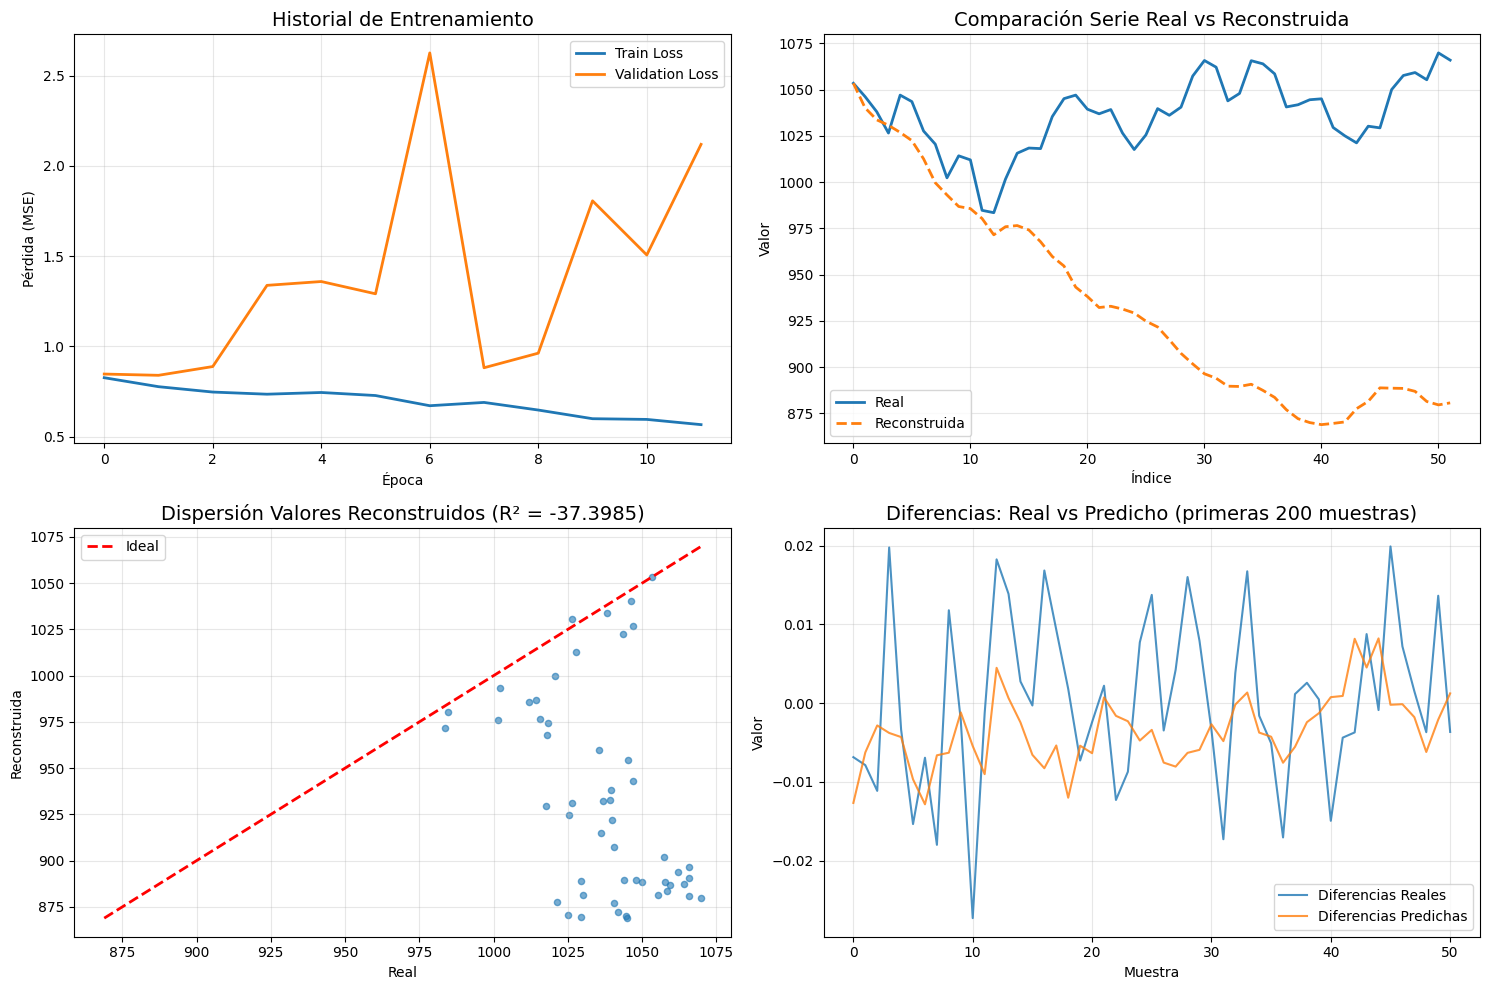

In [19]:
def graficar_resultados(train_losses, val_losses, true_recon, pred_recon, targets_denorm, predictions_denorm):
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # 9.1 Pérdidas de entrenamiento
    axes[0, 0].plot(train_losses, label='Train Loss', linewidth=2)
    axes[0, 0].plot(val_losses, label='Validation Loss', linewidth=2)
    axes[0, 0].set_title('Historial de Entrenamiento', fontsize=14)
    axes[0, 0].set_xlabel('Época')
    axes[0, 0].set_ylabel('Pérdida (MSE)')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # 9.2 Comparación de series reconstruidas
    axes[0, 1].plot(true_recon, label='Real', linewidth=2)
    axes[0, 1].plot(pred_recon, label='Reconstruida', linestyle='--', linewidth=2)
    axes[0, 1].set_title('Comparación Serie Real vs Reconstruida', fontsize=14)
    axes[0, 1].set_xlabel('Índice')
    axes[0, 1].set_ylabel('Valor')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # 9.3 Dispersión de valores reconstruidos
    axes[1, 0].scatter(true_recon, pred_recon, alpha=0.6, s=20)
    min_val = min(true_recon.min(), pred_recon.min())
    max_val = max(true_recon.max(), pred_recon.max())
    axes[1, 0].plot([min_val, max_val], [min_val, max_val], 'r--', label='Ideal', linewidth=2)
    r2_val = r2_score(true_recon, pred_recon)
    axes[1, 0].set_title(f'Dispersión Valores Reconstruidos (R² = {r2_val:.4f})', fontsize=14)
    axes[1, 0].set_xlabel('Real')
    axes[1, 0].set_ylabel('Reconstruida')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # 9.4 Diferencias (primeras 200 muestras)
    axes[1, 1].plot(targets_denorm[:200], label='Diferencias Reales', alpha=0.8)
    axes[1, 1].plot(predictions_denorm[:200], label='Diferencias Predichas', alpha=0.8)
    axes[1, 1].set_title('Diferencias: Real vs Predicho (primeras 200 muestras)', fontsize=14)
    axes[1, 1].set_xlabel('Muestra')
    axes[1, 1].set_ylabel('Valor')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Generar gráficas
graficar_resultados(train_losses, val_losses, true_recon, pred_recon, targets, predictions)

### Estadísticas


ANÁLISIS ADICIONAL

Estadísticas de las diferencias (desnormalizadas):
  Media: 0.000231
  Desviación estándar: 0.010719
  Mínimo: -0.027306
  Máximo: 0.019911


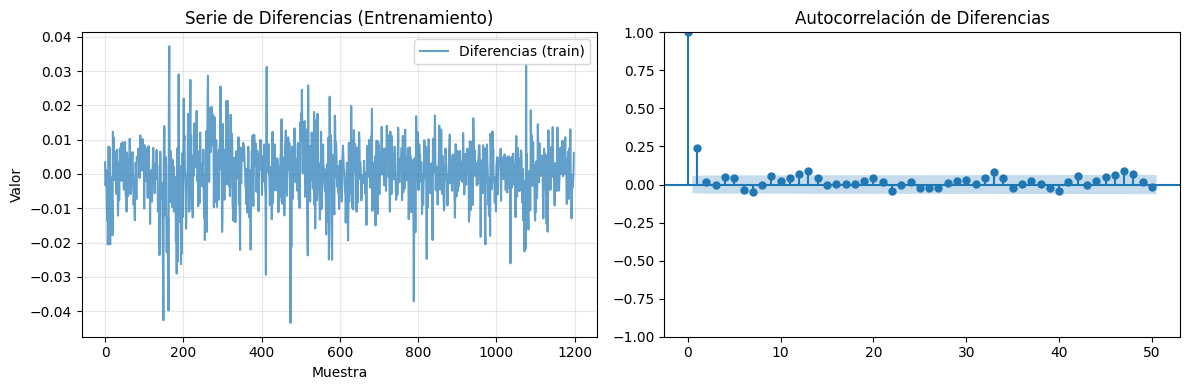

In [21]:
print("\n" + "="*50)
print("ANÁLISIS ADICIONAL")
print("="*50)

# Estadísticas de las diferencias
print(f"\nEstadísticas de las diferencias (desnormalizadas):")
print(f"  Media: {np.mean(targets):.6f}")
print(f"  Desviación estándar: {np.std(targets):.6f}")
print(f"  Mínimo: {np.min(targets):.6f}")
print(f"  Máximo: {np.max(targets):.6f}")

# Verificar estacionariedad visualmente
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(s_diff_train, label='Diferencias (train)', alpha=0.7)
axes[0].set_title('Serie de Diferencias (Entrenamiento)')
axes[0].set_xlabel('Muestra')
axes[0].set_ylabel('Valor')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Autocorrelación
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(s_diff_train, lags=50, ax=axes[1])
axes[1].set_title('Autocorrelación de Diferencias')
plt.tight_layout()
plt.show()